In [1]:
import os
from os.path import join
from os import getcwd
from pathlib import Path
from sys import path
import matplotlib.pyplot as plt
import logging


# Set Functions to Path
full_path = os.getcwd()
functions_path = join( Path(full_path).parents[0].parents[0].parents[0] )
path.append( functions_path  )

from ETL.ETL_func import *
from ML.label_methods import *
from ML.models import *
from Features.feature_generation import FeatureEngineer
from Backtesting.backtester import Backtester
from tasks.task_utils import create_logging

In [2]:
backtesting_folder = "/mnt/d/Tensor/tensortrader/backtests/tmp"

LOG_FILENAME = os.path.join( backtesting_folder,
                                f"Backtester_tmp.log")

print("Logging data at ", LOG_FILENAME)

logger = create_logging(LOG_FILENAME)

Logging data at  /mnt/d/Tensor/tensortrader/backtests/tmp/Backtester_tmp.log


# Parameters

In [3]:
symbols = [ 'BTCUSDT', 'ETHUSDT', 'LTCUSDT',  'ADAUSDT','BNBUSDT', 'BNBBTC' , 'EOSUSDT', 'ETCUSDT',
        'XMRBTC', 'TRXUSDT', 'XLMUSDT', 'IOTAUSDT',
        'MKRUSDT', 'DOGEUSDT']
n_days = 90
years_filter = [2022]
label_mode = 'return' # TBM, return, TA: Technical Indicator
technical_indicator = 'awesome_os' # macd_os , awesome_os
target_type = 'regression' # classification or regression
calculate_feat_importance = False


# Resampling Paramters
use_resampling = True
resampling = '15Min'

# number of candles to considered for exponentially weighted 
# volatility
span_volatility = 60 
outlier_cutoff = 0.0001
v_barrier_minutes = 10

# -----------------------------
# Return Signals Parameters
# -----------------------------

if label_mode == 'return':
    return_lag = 1
    long_short = (2,1)
    timestamp_col = 'Date'
    variable = 'Close'
    target_col_name = "{}_target_return_{}m".format(variable, int(resampling[:-3]) * return_lag)
    target_variable = target_col_name

# -----------------------------
# Triple Barrier Parameters
# -----------------------------
if label_mode == 'TBM':
    # Profit-Stop Loss ratio
    ptsl = [2,1]
   
    delta_vertical_b = pd.Timedelta(minutes = v_barrier_minutes) 

    # Volatility Parameters
    volatility_freq = 1 # In minutes
    delta_volatility = pd.Timedelta(minutes = volatility_freq)
    target_variable = 'label'

    # Position Type
    # 1: Long
    # -1: Short
    pt = 1
    n_jobs = -2
    max_nbytes = '0.8M'
    parallel_calculation = False

# -----------------------------
# Feature Engineering
# -----------------------------
feature_id = 1
conf_path = '../../../config/feature_eng.yml'

# -----------------------------
# Feature Selection
# -----------------------------
train_size = 0.7
mode = "mean_decrease"

# -----------------------------
# Model Training
# -----------------------------
n_splits = 5
n_iter = 2
test_period_length = 60 # minutes   
train_period_length = None                                                            
gap = 5
date_idx = "Date"
model_type = "XGB"
n_top_features = 20
max_n_estimators = 400

# Ref: https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tweedie-regression-objective-reg-tweedie
if target_type == 'classification':
    
    eval_metric = 'auc'
    objective = 'multi:softmax' 
    grow_policy = 'lossguide' 
    booster = 'gbtree'
    
elif target_type == 'regression':

    eval_metric = 'rmse' 
    objective = 'reg:squarederror'
    grow_policy = 'lossguide' 
    booster = 'gbtree' 


# -----------------------------
# Cost Analysis
# -----------------------------
trading_fee = 0.001

# Data Load

In [4]:
Loader = DataLoader(input_folder_db = "/mnt/c/Tensor/Database/Cryptos/")

In [5]:
data = Loader.load(n_days = n_days,
            symbols = symbols,
            years_filter = years_filter)

Reading file /mnt/c/Tensor/Database/Cryptos/BTCUSDT/2022_BTCUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/ETHUSDT/2022_ETHUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/LTCUSDT/2022_LTCUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/ADAUSDT/2022_ADAUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/BNBUSDT/2022_BNBUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/BNBBTC/2022_BNBBTC.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/EOSUSDT/2022_EOSUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/ETCUSDT/2022_ETCUSDT.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Cryptos/XMRBTC/2022_XMRBTC.parquet
 Max Date is  2022-12-16 15:37:00
Reading file /mnt/c/Tensor/Database/Crypt

In [6]:
data.columns

Index(['timestamp', 'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Clos Time', 'Quote Asset Volume', 'Number of Trades',
       'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore',
       'Date', 'Year', 'Ticker'],
      dtype='object')

In [7]:
if use_resampling:
    data = Loader.resampling(data, resampling)

In [8]:
data.shape

(121240, 9)

In [9]:
data.head()

,Ticker,timestamp,Open,High,Low,Close,Volume,Number of Trades,Date
0,ADAUSDT,2022-09-17 10:45:00,0.4750,0.4758,0.4744,0.4757,512435.2,476,2022-09-17 10:45:00
1,ADAUSDT,2022-09-17 11:00:00,0.4757,0.4770,0.4756,0.4766,882077.6,837,2022-09-17 11:00:00
2,ADAUSDT,2022-09-17 11:15:00,0.4765,0.4771,0.4755,0.4761,690090.2,780,2022-09-17 11:15:00
3,ADAUSDT,2022-09-17 11:30:00,0.4761,0.4767,0.4759,0.4759,419249.4,544,2022-09-17 11:30:00
4,ADAUSDT,2022-09-17 11:45:00,0.4759,0.4764,0.4755,0.4763,475444.1,455,2022-09-17 11:45:00


# Technical Indicator Signal

In [10]:
def calculate_signal(df, indicator, technical_indicator):
    
    # https://www.tradingview.com/support/solutions/43000501826-awesome-oscillator-ao/
    # Using Twin Peaks Strategy
    if technical_indicator == 'awesome_os':
        df[f'{indicator}_lag1'] = df[indicator].shift(1)
        df['changed'] = (df[[indicator,f'{indicator}_lag1']]
                        .apply(lambda x: x[indicator]*x[f'{indicator}_lag1'] < 0 , 
                               axis = 1))

        df['candle_type'] = np.where( df['Open'] < df['Close'], 1, -1)

        df['sign'] = np.sign(df[f'{indicator}_lag1'])  
        df['label'] = np.where( df['changed'] & (df['sign']  == -1)  , 1, 
                               np.where( df['changed'] & (df['sign']  == 1) , -1 , 0 ) ,
                              )

        return df
    
    elif technical_indicator == 'macd_os':
      # some logic

      return df
    
    else:
        ValueError(f"Stragey {self.technical_indicator} is not available")
        


In [11]:
if label_mode == 'TA':
    
    TA_signal = TechnicalSignal(technical_indicator)
    
    fast = 10
    slow = 120
    
    data = TA_signal.run(data = data, 
                         fast = fast, 
                         slow = slow)
    
    data = calculate_signal(data, 
                            indicator = f'AO_{fast}_{slow}', 
                            technical_indicator = technical_indicator)
    
    print(data.groupby(['Ticker'])['label'].value_counts())

In [12]:
# data[['timestamp','Close',f'AO_{fast}_{slow}',
#       'changed','sign','label']].tail(50)

In [14]:
# (data[['timestamp','Close',f'AO_{fast}_{slow}',
#       'changed','sign','label']]
#         .tail(1000).plot(x = 'timestamp', y = [f'AO_{fast}_{slow}']))

In [15]:
# (data[['timestamp','Close',f'AO_{fast}_{slow}','changed','sign','label']]
#         .tail(1000).plot(x = 'timestamp', y = ['Close']))

# Return Signals Labels

In [12]:
if label_mode == 'return':

    R_Signals = ReturnSignal(return_lag = return_lag,
                             target_col_name = target_col_name,
                             long_short = long_short,
                             data = data,
                             timestamp_col = timestamp_col,
                             variable = variable, 
                             span_volatility= span_volatility, 
                             outlier_cutoff = outlier_cutoff)
    
    data = R_Signals.run()
    
    if target_type == 'regression':
        target_variable = target_col_name
    elif target_type == 'classification':
        target_variable = 'label'
    
    print(data.groupby(['Ticker'])['label'].value_counts())

Calculating returns for ticker ADAUSDT
Getting volatility
Getting signals
Calculating returns for ticker BNBBTC
Getting volatility
Getting signals
Calculating returns for ticker BNBUSDT
Getting volatility
Getting signals
Calculating returns for ticker BTCUSDT
Getting volatility
Getting signals
Calculating returns for ticker DOGEUSDT
Getting volatility
Getting signals
Calculating returns for ticker EOSUSDT
Getting volatility
Getting signals
Calculating returns for ticker ETCUSDT
Getting volatility
Getting signals
Calculating returns for ticker ETHUSDT
Getting volatility
Getting signals
Calculating returns for ticker IOTAUSDT
Getting volatility
Getting signals
Calculating returns for ticker LTCUSDT
Getting volatility
Getting signals
Calculating returns for ticker MKRUSDT
Getting volatility
Getting signals
Calculating returns for ticker TRXUSDT
Getting volatility
Getting signals
Calculating returns for ticker XLMUSDT
Getting volatility
Getting signals
Calculating returns for ticker XMRBTC

<AxesSubplot:xlabel='timestamp'>

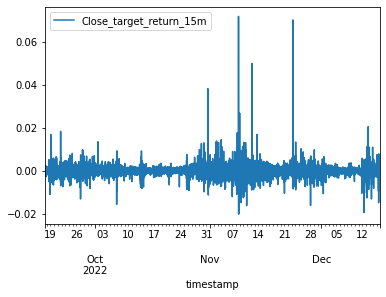

In [13]:
data[data['Ticker'] == 'BNBBTC'].plot(x = 'timestamp', y = 'Close_target_return_15m')

In [15]:
data.to_parquet("/mnt/c/Tensor/Database/Cryptos/Dataframe_Wavelet/Tensor_Portfolio.parquet")

# TBM Labels

In [47]:
if label_mode == 'TBM':

    dfs = []

    for ticker in symbols:

        print("Get TBM labels for ticker", ticker)

        df = data[data['Ticker'] == ticker].copy()
        df = df.set_index('timestamp').copy()

        TBM_labels = TripleBarrierMethod(df,
                                        ticker,
                                        ptsl,
                                        delta_vertical_b,
                                        pt,
                                        delta_volatility,
                                        span_volatility,
                                        n_jobs,
                                        parallel_calculation,
                                        max_nbytes )

        TBM_labels.run()

        df = TBM_labels.data.copy()

        dfs.append(df)

        del df

    data = pd.concat(dfs)

    del dfs
    
    print(data.groupby(['Ticker'])['label'].value_counts())

# Cost Analysis 

In [49]:
Label_Backtest = Backtester(logger)

key:  use_adj_strategy  value True
key:  v_barrier_minutes  value 10
key:  trading_fee  value 0.001

Analyzing performance for  ETHUSDT

ML Strategy: Saldo after Backtesting for ml_performance
                size 1 unit of the Coin $USD
 Initial Investment: 1060.67
 Final Performance: 1735.32
 Performance Return: 0.64
Number of Trades: 225.0
Total Cost USDT: 519.58

ML Strategy: Saldo after Backtesting for ml_adj_performance
                size 1 unit of the Coin $USD
 Initial Investment: 1060.67
 Final Performance: 1729.35
 Performance Return: 0.63
Number of Trades: 225.0
Total Cost USDT: 508.14
<class 'matplotlib.figure.Figure'>


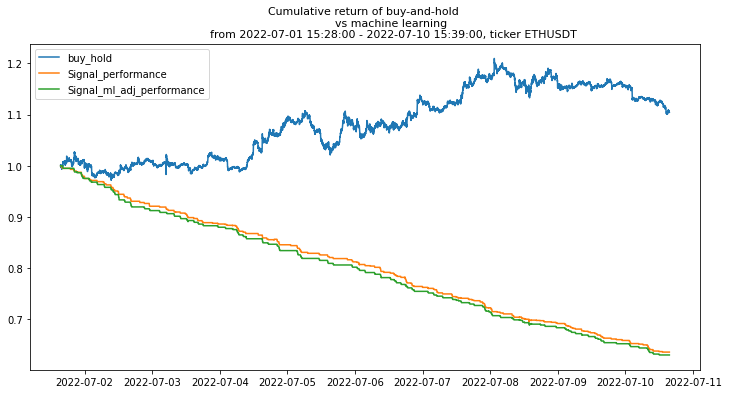

In [50]:
backtesting_restuls = Label_Backtest.vectorize_backtesting(ds = data.copy(),
                      backtesting_folder = backtesting_folder,
                      modus =  'signal_validation', 
                      use_adj_strategy = True,
                      v_barrier_minutes = v_barrier_minutes, 
                      trading_fee = 0.001)

In [12]:
backtesting_file = "backtetisting_file.parquet"

In [13]:
backtesting_restuls.shape

(13008, 24)

In [14]:
Label_Backtest.store_backtesting_results_parquet( 
                                backtesting_df =  backtesting_restuls,
                                file_name =  backtesting_file,
                                storage_folder = backtesting_folder )


# Feature Engineerer

In [33]:
feature = FeatureEngineer(feature_id  = feature_id, 
                       conf_path = conf_path)

In [44]:
feature.read_conf()

print(feature.conf['Feature_Engineering'][1]['ta'])

[{'kind': 'sma', 'length': 10, 'offset': 1}, {'kind': 'sma', 'length': 60, 'offset': 1}, {'kind': 'vwma', 'length': 10, 'offset': 1}, {'kind': 'vwma', 'length': 60, 'offset': 1}, {'kind': 'bbands', 'length': 10, 'offset': 1}, {'kind': 'bbands', 'length': 60, 'offset': 1}, {'kind': 'macd', 'fast': 5, 'slow': 60, 'offset': 1}, {'kind': 'rsi', 'length': 10, 'offset': 1}, {'kind': 'atr', 'length': 10, 'offset': 1}, {'kind': 'pdist', 'offset': 1}]


In [34]:
data = feature.calculate_features(data).copy()

Calculating Technical Indicators for ticker ETHUSDT
Calculating returns for ticker ETHUSDT


# Feature Selection

In [17]:
data.reset_index(inplace = True)

In [18]:
cat_columns = 'Ticker'
data = feature.add_dummies(data, cat_columns).copy()

In [19]:
cols_to_drop = ['Date', 'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Clos Time', 'Quote Asset Volume', 'Number of Trades',
       'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore',
       'Year', 'threshold', 't1', 'label','timestamp']

if label_mode == 'return':
    cols_to_drop.append(target_col_name)

predictors_list = list(set(data.columns) - set(cols_to_drop))

In [20]:
X_train, X_test, y_train, y_test = feature.train_test_split_multiple_ts(data, predictors_list, train_size, target_variable)

In [21]:
predictors_list = X_train.columns

if calculate_feat_importance:
    feat_importance = feature.feature_selection(predictors_list = predictors_list, 
                                                X_train = X_train, 
                                                y_train = y_train, 
                                                mode = mode, 
                                                target_type = target_type)
    
    feature_selected = list(feat_importance.index[:n_top_features])
else:
    feature_selected = list(predictors_list)


# Model Training

In [22]:
XGB_trainer = ML_trainer(train_length = train_period_length,
            test_length = test_period_length, 
            n_splits = n_splits,
            gap = gap, 
            date_idx = date_idx,
            model_type =  model_type, 
            symbols = symbols)

In [23]:
print(XGB_trainer)

ML Trainer for model XGB,                
Test size 60                
Number of folds 5                
Symbols ['ETHUSDT']


In [24]:
imbalance_classes_mode = "class_weights"

report, y_pred = XGB_trainer.fit(X_train, 
                        X_test, 
                        y_train, 
                        y_test,
                        feature_selected, 
                        imbalance_classes_mode,
                        target_type = target_type,         
                        n_iter = n_iter,
                        max_n_estimators = max_n_estimators, 
                        eval_metric = eval_metric, 
                        objective = objective, 
                        grow_policy = grow_policy, 
                        booster = booster)

 Dataframe training size:  (30162, 41)
key:  n_iter  value 2
key:  max_n_estimators  value 400
key:  eval_metric  value rmse
key:  objective  value reg:squarederror
key:  grow_policy  value lossguide
key:  booster  value gbtree
Training XGB Classifier Model with class weights
accuracy score: 0.3906
              precision    recall  f1-score   support

          -1       0.47      0.64      0.54      5933
           0       0.40      0.09      0.14      4166
           1       0.23      0.32      0.27      2828

    accuracy                           0.39     12927
   macro avg       0.37      0.35      0.32     12927
weighted avg       0.39      0.39      0.35     12927



In [25]:
from sklearn.metrics import mean_squared_error

key:  use_adj_strategy  value True
key:  v_barrier_minutes  value 10
key:  trading_fee  value 0.001
(43089, 61)
(12927, 61)

Analyzing performance for  ETHUSDT

ML Strategy: Saldo after Backtesting for ml_performance
                size 1 unit of the Coin $USD 
 Initial Investment:  1025.27 
 Final Performance:  1029.62 
 Performance Return:  0.0 
Number of Trades:  2550.0 
Total Cost USDT: 6244.83

ML Strategy: Saldo after Backtesting for ml_adj_performance
                size 1 unit of the Coin $USD 
 Initial Investment:  1025.27 
 Final Performance:  1089.31 
 Performance Return:  0.06 
Number of Trades:  2550.0 
Total Cost USDT: 3216.0
<class 'matplotlib.figure.Figure'>


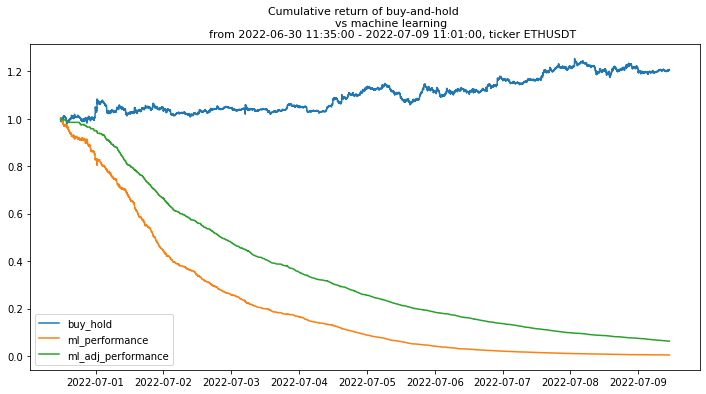

In [26]:
if target_type == 'regression':
    
    df_signals = (pd.DataFrame(y_pred.rename(R_Signals.target_col_name))
            .join(data.set_index('Date')
            .filter(['threshold'])))
    
    df_signals['label'] = R_Signals.calculate_signals(df_signals, long_short)
    
    Label_Backtest.vectorize_backtesting(ds = data.copy(),
                          modus =  'ML_performance', 
                          y_pred = df_signals['label'],
                          backtesting_folder = backtesting_folder,
                          use_adj_strategy  = True,
                          v_barrier_minutes = v_barrier_minutes, 
                          trading_fee = 0.001)

    
else:    
    Label_Backtest.vectorize_backtesting(ds = data.copy(),
                          modus =  'ML_performance', 
                          y_pred = y_pred,
                          backtesting_folder = backtesting_folder,
                          use_adj_strategy  = True,
                          v_barrier_minutes = v_barrier_minutes, 
                          trading_fee = 0.001)